In [1]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDrift
import random
from matplotlib.colors import ListedColormap
from datetime import date, timedelta

sys.path.append("..")

from utils.utils import *
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

2022-07-07 11:07:58,781 INFO cyclops.orm     - Database setup, ready to run queries!


In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022"

In [3]:
admin_data, x, y = get_gemini_data(PATH)

2022-07-07 11:07:58,827 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-07-07 11:07:59,181 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-07-07 11:07:59,332 INFO cyclops.feature_handler - Loading features from file...
2022-07-07 11:07:59,334 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-07 11:07:59,335 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-07 11:07:59,364 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-07-07 11:08:04,201 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-07-07 11:08:12,948 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


## Create Data Streams

In [4]:
#####################################################
## a given date contains data from previous two weeks 
#####################################################

start_date = date(2018, 1, 1)
end_date = date(2020, 8, 1)

def daterange(start_date, end_date, stride, window):
    for n in range(int((end_date - start_date).days)):
        if start_date + timedelta(n*stride+window) < end_date:
            yield start_date+ timedelta(n*stride)
            

def get_streams(x, y, admin_data, start_date, end_date, stride, window):
    target_stream_x = []
    target_stream_y = [] 
    measure_dates = []

    admit_df = admin_data[[ENCOUNTER_ID,ADMIT_TIMESTAMP]].sort_values(by=ADMIT_TIMESTAMP)
    for single_date in daterange(start_date, end_date, stride, window):
        if single_date.month ==1 and single_date.day == 1:
            print(single_date.strftime("%Y-%m-%d"),"-",(single_date+timedelta(days=window)).strftime("%Y-%m-%d"))
        encounters_inwindow = admit_df.loc[((single_date+timedelta(days=window)).strftime("%Y-%m-%d") > admit_df[ADMIT_TIMESTAMP].dt.strftime("%Y-%m-%d")) 
                           & (admit_df[ADMIT_TIMESTAMP].dt.strftime("%Y-%m-%d") >= single_date.strftime("%Y-%m-%d")), ENCOUNTER_ID].unique()
        encounter_ids = x.index.get_level_values(0).unique()
        x_inwindow = x.loc[x.index.get_level_values(0).isin(encounters_inwindow)]
        y_inwindow = y[np.in1d(encounter_ids, encounters_inwindow)]
        if not x_inwindow.empty:
            target_stream_x.append(x_inwindow)
            target_stream_y.append(y_inwindow)
            measure_dates.append((single_date+timedelta(days=window)).strftime("%Y-%m-%d"))
    return(target_stream_x, target_stream_y, measure_dates)

x_test_stream, y_test_stream, measure_dates_test = get_streams(x, y, admin_data, start_date, end_date, stride=1, window=1)

2018-01-01 - 2018-01-02
2019-01-01 - 2019-01-02
2020-01-01 - 2020-01-02


## Rolling Window (14 days)

In [5]:
#####################################################
## rolling window - not cumulatively including data and no adjustment made when drift occurs
##################################################### 
def rolling_window(stat_window, lookup_window, stride, num_timesteps, series, threshold,custom_ref=None):

    p_vals = np.asarray([])
    dist_vals = np.asarray([])
    i = 0 
    if custom_ref is not None:
        prev = reshape_inputs(custom_ref, num_timesteps)
        
    while i+stat_window+lookup_window < len(series):
        feat_index = 0
        
        if custom_ref is None:
            prev = pd.concat(series[i:i+stat_window])
            prev = prev[~prev.index.duplicated(keep='first')]
            prev = reshape_inputs(prev, num_timesteps)
            #prev = prev.reshape(prev.shape[0]*prev.shape[1],prev.shape[2])
            
        next = pd.concat(series[i+lookup_window:i+lookup_window+stat_window])
        next = next[~next.index.duplicated(keep='first')]
        next = reshape_inputs(next, num_timesteps)
        #next = next.reshape(next.shape[0]*next.shape[1],next.shape[2])
        
        if next.shape[0]<=2 or prev.shape[0]<=2:
            break
        
        ## run distribution shift check here
        cd = MMDDrift(prev, backend='pytorch', p_val=.05)
        preds = cd.predict(next, return_p_val=True, return_distance=True)
        p_val = preds['data']['p_val']
        if p_val < threshold:
            print("P-value below threshold.")
            print(i,"-", i+stat_window,"-->",i+lookup_window,"-",i+stat_window+lookup_window,"\tP-Value: ",p_val)
        dist_val = preds['data']['distance']
        dist_vals = np.concatenate((dist_vals, np.repeat(dist_val, 1)))
        p_vals = np.concatenate((p_vals, np.repeat(p_val, 1)))
        i += stride
            
    return dist_vals, p_vals

## Set constant reference distribution

In [6]:
threshold = 0.05
num_timesteps = 6
stat_window=30
lookup_window=120
stride=1
dataset="covid"
hospital = ["SBK", "UHNTG", "THPC", "THPM", "UHNTW", "SMH","MSH"]
outcome="mortality"

random.seed(1)

feature_handler = FeatureHandler()
feature_handler.load(PATH, "features")

# Get types of columns
numerical_cols = feature_handler.get_numerical_feature_names()["temporal"]
numerical_cols += ["age"]

(x_train_covid, y_train_covid), (x_val_covid, y_val_covid), (x_test_covid, y_test_covid), feats, orig_dims, admin_data = import_dataset_hospital(admin_data, x, y, dataset, outcome, hospital, shuffle=True)    
x_train_covid_normalized = x_train_covid.copy()
x_val_covid_normalized = x_val_covid.copy()
x_test_covid_normalized = x_test_covid.copy()

for col in numerical_cols:
    scaler = StandardScaler().fit(x_train_covid[col].values.reshape(-1, 1))
    x_train_covid_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(x_train_covid[col].values.reshape(-1, 1))),
        index=x_train_covid[col].index,
    )
    x_val_covid_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(x_val_covid[col].values.reshape(-1, 1))),
        index=x_val_covid[col].index,
    )
    x_test_covid_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(x_test_covid[col].values.reshape(-1, 1))),
        index=x_test_covid[col].index,
    )

2022-07-07 11:15:46,911 INFO cyclops.feature_handler - Loading features from file...
2022-07-07 11:15:46,914 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-07 11:15:46,915 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-07 11:15:46,945 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-07-07 11:15:51,668 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


In [ ]:
dist_vals_test_covid, p_vals_test_covid = rolling_window(stat_window, lookup_window, stride, num_timesteps, x_test_stream, threshold, x_val_covid)

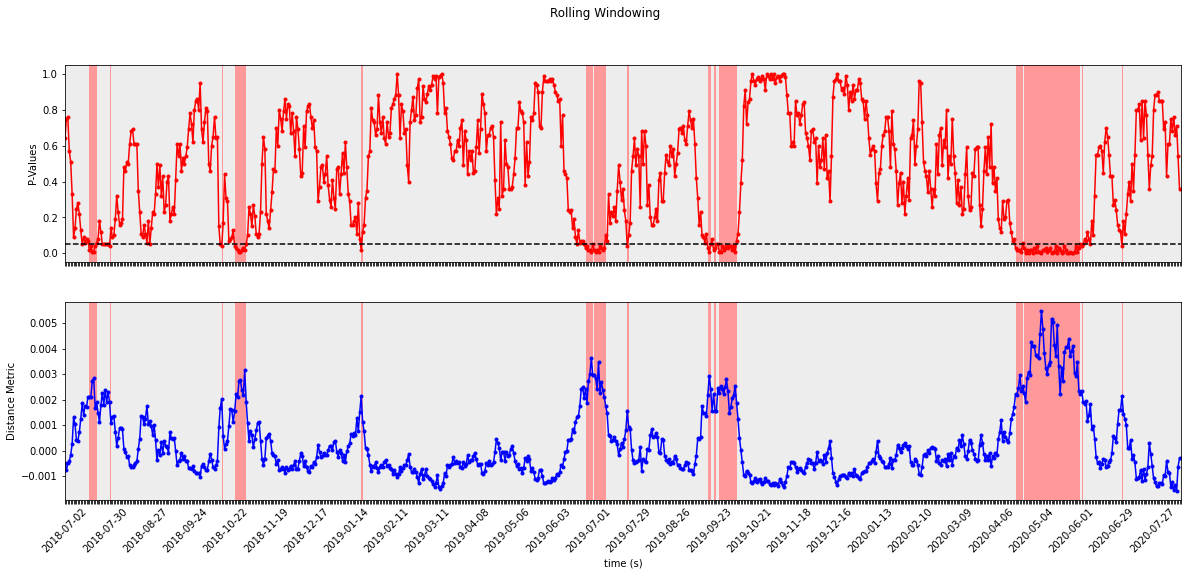

In [10]:
end = len(p_vals_test_covid)
measure_dates_test_covid = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window*2)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_covid[1:end],
     'p_val_val': p_vals_test_covid[1:end],
     'dist metric_val': dist_vals_test_covid[1:end],
     'detection': np.where(p_vals_test_covid[1:end]<threshold,1,0)
    })


cmap = ListedColormap(['lightgrey','red'])
ax1.plot(measure_dates_test_covid[1:end], p_vals_test_covid[1:end], '.-', color="red")
ax1.set_xlim(measure_dates_test_covid[1],measure_dates_test_covid[end])
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
        
ax2.plot(measure_dates_test_covid[1:end], dist_vals_test_covid[1:end], '.-',color="blue")
ax2.set_xlim(measure_dates_test_covid[1],measure_dates_test_covid[end])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

In [ ]:
dist_vals_test_covid, p_vals_test_covid = rolling_window(stat_window, lookup_window, stride, num_timesteps, x_test_stream, threshold, x_test_covid)

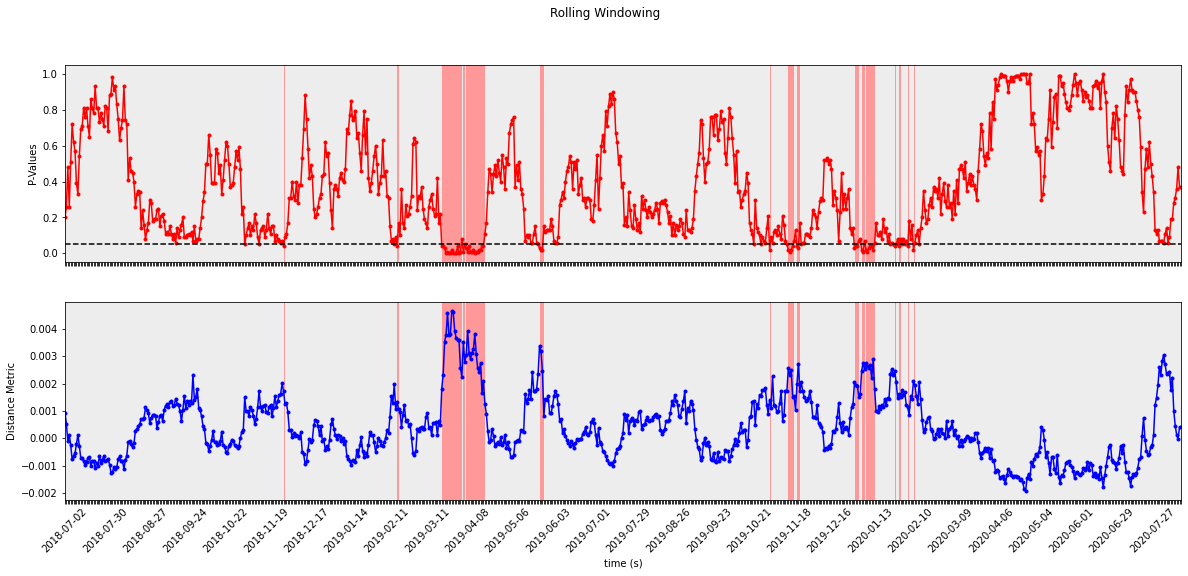

In [9]:
end = len(p_vals_test_covid)
measure_dates_test_covid = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window*2)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_covid[1:end],
     'p_val_val': p_vals_test_covid[1:end],
     'dist metric_val': dist_vals_test_covid[1:end],
     'detection': np.where(p_vals_test_covid[1:end]<threshold,1,0)
    })


cmap = ListedColormap(['lightgrey','red'])
ax1.plot(measure_dates_test_covid[1:end], p_vals_test_covid[1:end], '.-', color="red")
ax1.set_xlim(measure_dates_test_covid[1],measure_dates_test_covid[end])
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
        
ax2.plot(measure_dates_test_covid[1:end], dist_vals_test_covid[1:end], '.-',color="blue")
ax2.set_xlim(measure_dates_test_covid[1],measure_dates_test_covid[end])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()